# Load Modules and Data

In [126]:
# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show all import functions, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import tabulate as tab
import seaborn as sb

from sklearn.metrics import jaccard_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

from IPython.display import HTML
from IPython.display import display

In [2]:
with open("credit_record.csv") as f:
    credit_record = f.read_csv()

with open("application_record.csv") as f:
    application_record = f.read_csv()


# Preprocessing
The data is split between two different files, so they need to be combined. Also, I need to create a variable which labels each account as either good or bad based on whether it defaulted. I also need to code categorical data so that it can be used in models.

In [139]:
credit_wide = credit_record.pivot(index = 'ID', columns = "MONTHS_BALANCE", values = "STATUS")
credit_wide = pd.DataFrame(credit_wide)

grouped_credit = credit_record.groupby('ID') #group the credit data by ID
credit_wide['final_month'] = grouped_credit['MONTHS_BALANCE'].max()#create variable with the final month for each account
credit_wide['start_month'] = grouped_credit['MONTHS_BALANCE'].min() #create variable with the starting month for each account

credit_thin = credit_wide.loc[:, credit_wide.columns.isin(['ID', 'final_month', 'start_month'])]
credit_thin = credit_thin.assign(open_window = credit_thin.final_month - credit_thin.start_month) #calculate how many months the acocunt was open for
credit_thin.columns.values
credit_thin = credit_thin[credit_thin['open_window'] > 4] #remove account that have been open less than 4 months



In [4]:
credit_full = pd.merge(credit_thin, credit_record, on = 'ID')

credit_full['bad'] = np.where(((credit_full['STATUS'] == '2')| (credit_full['STATUS'] == '3')| (credit_full['STATUS'] == '4') |(credit_full['STATUS'] =='5')), 1, 0) # bad is 1 if the account is overdue and good if it is 0
credit_full['bad'] = credit_full['bad'].astype(np.int8)

grouped_credit = credit_full.groupby('ID')
max_bad = grouped_credit.max('bad')
credit_full = max_bad.reset_index()


In [93]:
full_data = pd.merge(credit_full, application_record, on = 'ID') #join the application record and credit record data by ID

In [92]:
#Check to make sure there's not a bunch of NAs
print(full_data.isna().any()) #note that only occupation_type contains missing values

ID                     False
final_month            False
start_month            False
open_window            False
MONTHS_BALANCE         False
bad                    False
CODE_GENDER            False
FLAG_OWN_CAR           False
FLAG_OWN_REALTY        False
CNT_CHILDREN           False
AMT_INCOME_TOTAL       False
NAME_INCOME_TYPE       False
NAME_EDUCATION_TYPE    False
NAME_FAMILY_STATUS     False
NAME_HOUSING_TYPE      False
DAYS_BIRTH             False
DAYS_EMPLOYED          False
FLAG_MOBIL             False
FLAG_WORK_PHONE        False
FLAG_PHONE             False
FLAG_EMAIL             False
OCCUPATION_TYPE         True
CNT_FAM_MEMBERS        False
dtype: bool

In [7]:
full_data = full_data.replace(np.nan, 'NaN') #replace np.nan with string Nan so that OrdinalEncoder will work
encoder = OrdinalEncoder()
cdf = encoder.fit_transform(full_data.loc[:,['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE']]) #NOTE: NaN occupation_type is coded as 12
cdf_coded = pd.DataFrame(cdf, columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE']) 
int_data = full_data.select_dtypes(include = ['float64', 'int64', 'int8'])
cdf_coded['ID'] = int_data['ID']
df = pd.merge(int_data, cdf_coded)

# Visualizations

This first graph is to get an idea of what percent of the accounts in the data set are good versus bad. We can see that this is a very unbalanced data set.

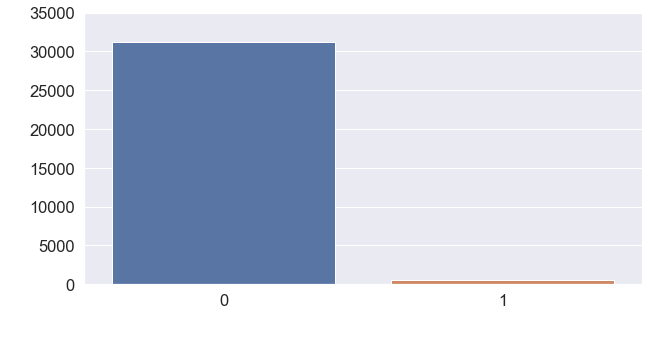

In [146]:
f = sb.countplot(x = "bad", data = df)
sb.set(font_scale=1.5)
f.set_ylim(top = 150000)
f.set_xlabel(' ')
f.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
f.set_ylim(top=35000)


plt.show()

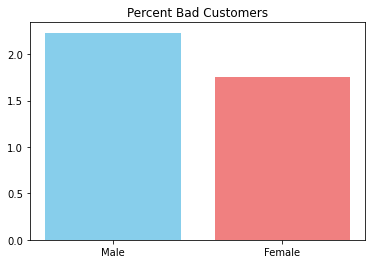

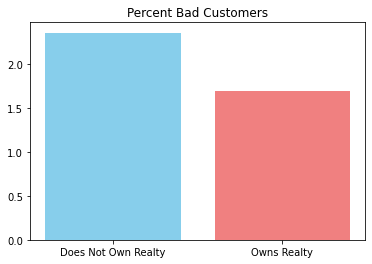

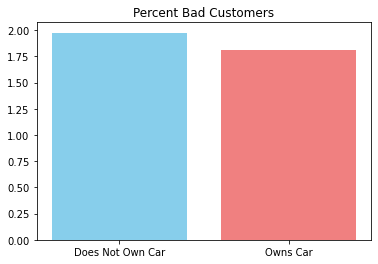

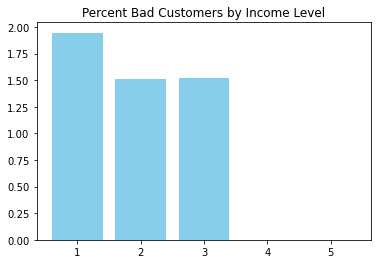

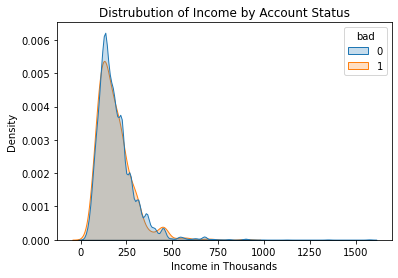

In [124]:
# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show all raw input code, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

#gender
female = df[df['CODE_GENDER'] == 0]
female_sum = len(female.index)
female_bad = len(female[female['bad'] == 1].index)

male = df[df['CODE_GENDER'] == 1]
male_sum = len(male.index)
male_bad = len(male[male['bad'] == 1].index)

f1 = plt.figure()
plt.bar(['Male', 'Female'], [male_bad*100/male_sum, female_bad*100/female_sum], color = ['skyblue', 'lightcoral'])
plt.title("Percent Bad Customers")

#flag_own_realty
own = df[df['FLAG_OWN_REALTY'] == 1]
own_sum = len(own.index)
own_bad = len(own[own['bad'] == 1].index)

no_own = df[df['FLAG_OWN_REALTY'] == 0]
no_own_sum = len(no_own.index)
no_own_bad = len(no_own[no_own['bad'] == 1].index)
pl3 = plt.figure()
plt.bar(['Does Not Own Realty', 'Owns Realty'], [no_own_bad*100/no_own_sum, own_bad*100/own_sum], color = ['skyblue', 'lightcoral'])
plt.title("Percent Bad Customers")

#flag_own_car
owncar = df[df['FLAG_OWN_CAR'] == 1]
owncar_sum = len(owncar.index)

owncar_bad = len(owncar[owncar['bad'] == 1].index)

no_owncar = df[df['FLAG_OWN_CAR'] == 0]
no_owncar_sum = len(no_owncar.index)
no_owncar_bad = len(no_owncar[no_owncar['bad'] == 1].index)

pl1 = plt.figure()
plt.bar(['Does Not Own Car', 'Owns Car'], [no_owncar_bad*100/no_owncar_sum, owncar_bad*100/owncar_sum], color = ['skyblue', 'lightcoral'])
plt.title("Percent Bad Customers")

#AMT_INCOME_TOTAL - bar plot

#create income levels
min_inc = df['AMT_INCOME_TOTAL'].min()
max_inc = df['AMT_INCOME_TOTAL'].max()
inc_range = max_inc-min_inc

inc_1 = df[df['AMT_INCOME_TOTAL'] <= (min_inc+(0.2*inc_range))]
inc_1_sum = len(inc_1.index)
inc_1_bad = len(inc_1[inc_1['bad'] == 1].index)
inc_2 = df[(df['AMT_INCOME_TOTAL'] <= (min_inc+(0.4*inc_range))) & (df['AMT_INCOME_TOTAL'] > (min_inc+(0.2*inc_range)))]
inc_2_sum = len(inc_2.index)
inc_2_bad = len(inc_2[inc_2['bad'] == 1].index)
inc_3 = df[(df['AMT_INCOME_TOTAL'] <= (min_inc+(0.6*inc_range))) & (df['AMT_INCOME_TOTAL'] > (min_inc+(0.4*inc_range)))]
inc_3_sum = len(inc_3.index)
inc_3_bad = len(inc_3[inc_3['bad'] == 1].index)
inc_4 = df[(df['AMT_INCOME_TOTAL'] <= (min_inc+(0.8*inc_range))) & (df['AMT_INCOME_TOTAL'] > (min_inc+(0.6*inc_range)))]
inc_4_sum = len(inc_4.index)
inc_4_bad = len(inc_4[inc_4['bad'] == 1].index)
inc_5 = df[(df['AMT_INCOME_TOTAL'] > (min_inc+(0.8*inc_range)))]
inc_5_sum = len(inc_5.index)
inc_5_bad = len(inc_5[inc_5['bad'] == 1].index)

pl2 = plt.figure()
plt.bar(['1', '2', '3', '4', '5'], [inc_1_bad*100/inc_1_sum, inc_2_bad*100/inc_2_sum, inc_3_bad*100/inc_3_sum, inc_4_bad*100/inc_4_sum, inc_5_bad*100/inc_5_sum], color = ['skyblue'])
plt.title("Percent Bad Customers by Income Level")


pl5 = plt.figure()
densPlot = sb.kdeplot(x=df['AMT_INCOME_TOTAL']/1000, hue = df['bad'], common_norm = False, fill = True)
plt.title('Distrubution of Income by Account Status')
plt.Axes.set_xlabel(densPlot, xlabel = 'Income in Thousands')

plt.show()

In [12]:
data_y = df.loc[:, df.columns.isin(['bad'])] #dependent variable is whether the account is bad
#data_x_small = df.loc[:, df.columns.isin(['AMT_INCOME_TOTAL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'])] #select independent variables
data_x = df.loc[:, df.columns != 'bad']
data_x_small = skl.preprocessing.StandardScaler().fit(data_x).transform(data_x) #normalize the dataset

train_x, test_x, train_y, test_y  = train_test_split(data_x_small, data_y, test_size = 0.2, random_state = 99)#split data into train and test sets


# Fit Models 

## Logistic Regression

First I'll try fitting a logistic regression model. Based off of the previous visualizations, it is clear that things like owning realty, owning a car, and income are relevant predictors of whether an account will be good or bad, however, the L1 penalty will help provide a feature selection, so for now I'm keeping all variables in the model.

In [18]:
#fit logistic regression
regr = skl.linear_model.LogisticRegression(C=0.01, solver='liblinear', penalty = 'l1', class_weight = "balanced")

regr.fit(train_x, train_y.values.ravel()) #ravel "flattens" the y values into long form


LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   solver='liblinear')

*It's important to use class_weight = "balanced" because this dataset is extremely unbalanced (ie. there are way more good accounts than bad). The class_weight parameter will weight the importance of correctly identifying a bad account more heavily than the importance of correctly identifying a account. If we didn't do this, then the model would predict every single account as good, because that's the best way to be correct most frequently.*

*I chose to go with an L1 penalty, for a few reasons. Firstly, since an L2 penalty takes the square of the weights it is not suitable for a dataset with many outliers, since the outliers could skew the results very quickly. Second, since L1 penalty shrinks weights to zero, rather than just close to zero, it performs a feature selection which is useful in this case where some of the variables might be highly correlated (ie. owning realty and income for example).*

In [58]:
y_hat = regr.predict(test_x)
y_hat_prob = regr.predict_proba(test_x)

Confusion matrix:


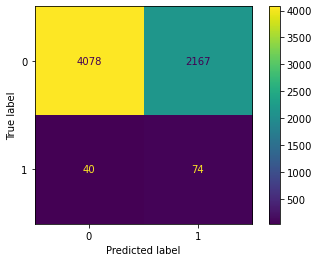

In [133]:
print('Confusion matrix:')
ConfusionMatrixDisplay.from_estimator(regr, test_x, test_y)

In [56]:
print(f'Jaccard score: {round(jaccard_score(test_y, y_hat), 4)}')
print(f'Accuracy score: {round(metrics.accuracy_score(test_y, y_hat), 4)}')

Jaccard score: 0.0324
Accuracy score: 0.6529


## Classification Tree
A classification tree classifies data by creating "branches" at each predictore variable.

In [22]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 10, class_weight = "balanced")

*Entropy is another word for the amount of disorder. If the classification tree works well, each node will have low entropy because the data will be split such that the two created groups are as purely one category or another as possible (ie. all the bad accounts would be in one group and all the good accounts in the other)*

In [23]:
tree.fit(train_x, train_y)
pred = tree.predict(test_x) #Use the model to predict the test x set

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10)

Confusion matrix:
[[  60   54]
 [1492 4753]]


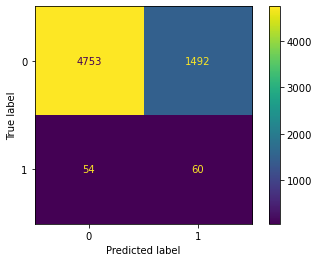

In [138]:
ConfusionMatrixDisplay.from_estimator(tree, test_x, test_y)

In [55]:
print(f'Jaccard score: {round(jaccard_score(test_y, pred), 4)}')
print(f'Accuracy: {round(metrics.accuracy_score(test_y, pred), 4)}')

Jaccard score: 0.0374
Accuracy score: 0.7569


## K-Nearest Neighbors
K-nearest neighbors classifies cases by finding the k number of most similar labeled cases, and then labeling the unknown case by assuming it falls into the same category as the cases with similar attributes.

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')

In [34]:
knn.fit(train_x, train_y.values.ravel())

KNeighborsClassifier()

In [35]:
neighbor = knn.predict(test_x)

Confusion matrix:
[[   8  106]
 [   6 6239]]
Accuracy score: 0.9824
Jaccard score: 0.0667


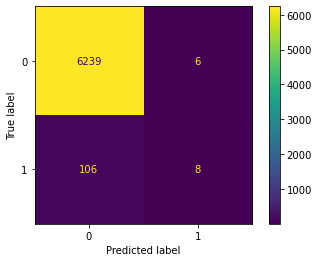

In [136]:
print('Confusion matrix:')
print(skl.metrics.confusion_matrix(test_y, neighbor, labels = [1,0]))
print(f'Accuracy score: {round(metrics.accuracy_score(test_y, neighbor), 4)}')
print(f'Jaccard score: {round(jaccard_score(test_y, neighbor), 4)}')
ConfusionMatrixDisplay.from_estimator(knn, test_x, test_y)

A good next step for tuning this model would be to try out different numbers of k-neighbors to see what works best. It also would be a good idea to try using fewer predictor variables in order to avoid overfitting.

## Random Forest
Random forest classifications basically take the idea behind a decision tree, but ratehr than having one single tree with nodes determined by entropy, this method creates many many trees randomly and then combines the information from all of the trees. In some cases this is more effective than a single classification tree because it does a good job of avoiding overfitting, however a drawback is that it is not as easily interpretable.

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
randTree = RandomForestClassifier(criterion = 'entropy', random_state = 2)

In [43]:
randTree.fit(train_x, train_y.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=2)

In [44]:
rTree_out = randTree.predict(test_x)

Confusion matrix:
[[   8  106]
 [   6 6239]]
Accuracy score: 0.9824
Jaccard score: 0.0667


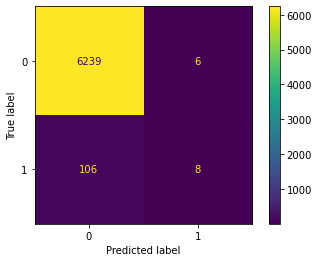

In [137]:
print('Confusion matrix:')
print(skl.metrics.confusion_matrix(test_y, rTree_out, labels = [1,0]))
print(f'Accuracy score: {round(metrics.accuracy_score(test_y, rTree_out), 4)}')
print(f'Jaccard score: {round(jaccard_score(test_y, rTree_out), 4)}')

ConfusionMatrixDisplay.from_estimator(randTree, test_x, test_y)